# AI Community @ Семинар № 5, весна 2018
## Семантическая сегментация. Локализация зданий с помощью обученной модели

In [23]:
from utils.segmentation.augmentation import SegmentationGenerator
from utils.segmentation import unet, segnet

from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import SGD, Adam
from keras.utils.training_utils import multi_gpu_model
import keras.backend as K

import cv2
from skimage.io import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import re
from os.path import join, basename, exists
from os import listdir, makedirs

%matplotlib inline

In [2]:
SIZE = (256, 256)
N_GPUS = 1
BATCH_SIZE = 16*N_GPUS

In [3]:
SMOOTH = 1.

def dice(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)


def dice_coef_loss(y_true, y_pred):
    return -dice(y_true, y_pred)

In [4]:
DATA_PATHS = {
    'TRAIN': {
        'IMAGES': 'data/train/images',
        'MASKS': 'data/train/masks',
    },
    'TEST': {
        'IMAGES': 'data/test/images',
        'MASKS': 'data/test/masks',
    }
}

train_datagen = SegmentationGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90.,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,
    shear_range=0.3,
    fill_mode='reflect'
)

train_iter = train_datagen.flow_from_directory(
    DATA_PATHS['TRAIN']['IMAGES'],
    DATA_PATHS['TRAIN']['MASKS'],
    target_size=SIZE, color_mode='grayscale',
    batch_size=BATCH_SIZE, shuffle=True
)

valid_datagen = SegmentationGenerator()

valid_iter = valid_datagen.flow_from_directory(
    DATA_PATHS['TEST']['IMAGES'],
    DATA_PATHS['TEST']['MASKS'],
    target_size=SIZE, color_mode='grayscale',
    batch_size=BATCH_SIZE, shuffle=False
)

Found 504 images.
Found 129 images.


In [5]:
x, y = next(train_iter)

In [8]:
img_idx = 0
img = (x[img_idx].squeeze() * 255.).astype(np.uint8)
mask = (y[img_idx].squeeze() * 255.).astype(np.uint8)

/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


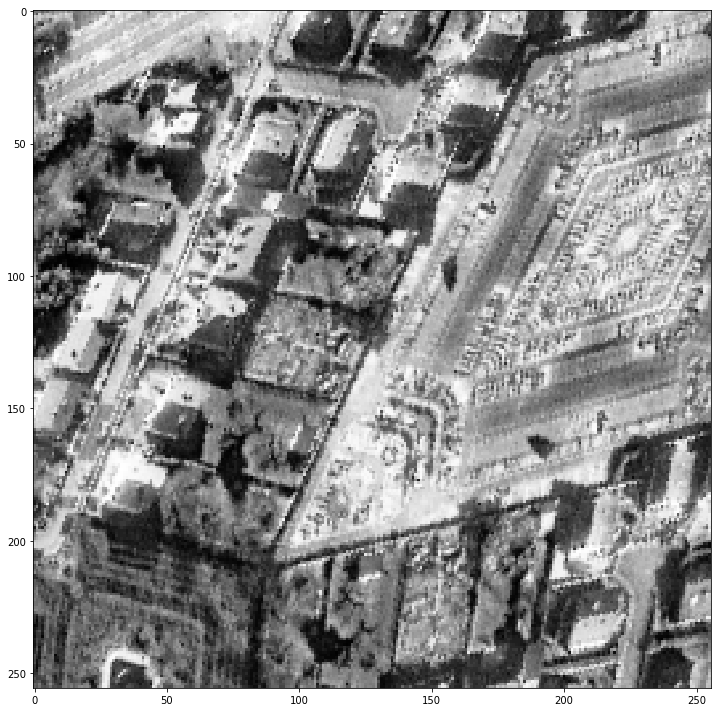

In [9]:
plt.figure(figsize=(10, 10))
imshow(img)

/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


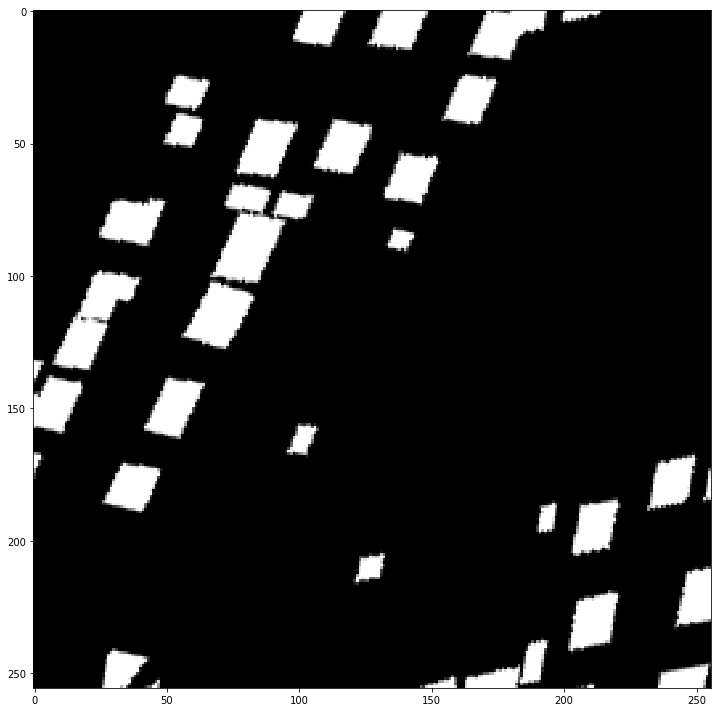

In [10]:
plt.figure(figsize=(10, 10))
imshow(mask, cmap='gray')

/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


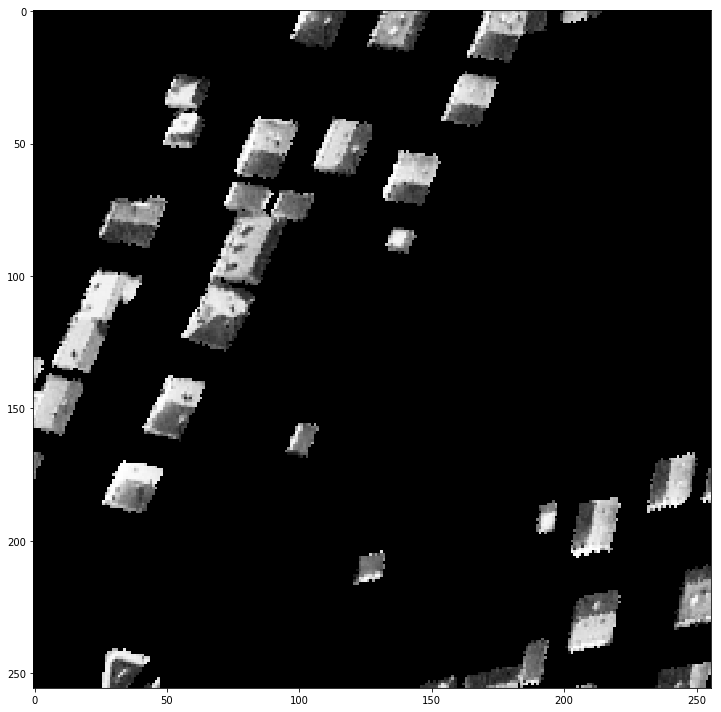

In [11]:
plt.figure(figsize=(10, 10))
masked_img = img.copy()
masked_img[mask == 0] = 0
imshow(masked_img, cmap='gray')

In [12]:
model = segnet.build_model(*SIZE, n_channels=1)
if N_GPUS >= 2:
    model = multi_gpu_model(model, N_GPUS)

In [13]:
optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
model.compile(loss=dice_coef_loss, optimizer=optimizer, metrics=[dice])

In [14]:
i = 0

In [ ]:
experiment_dir = 'segnet_{}x{}'.format(*SIZE)
models_dir = join(experiment_dir, 'models')
log_dir = join(experiment_dir, 'log')
if not exists(models_dir):
    makedirs(models_dir)
if not exists(log_dir):
    makedirs(log_dir)
i += 1
modelname = 'segnet' + str(i)
modelpath = join(models_dir, modelname)
tb_log_dir = join(log_dir, modelname)

model.fit_generator(
    train_iter,
    epochs=100,
    callbacks=[
        ModelCheckpoint(filepath=modelpath, monitor='val_dice', period=1),
        TensorBoard(log_dir=tb_log_dir, batch_size=BATCH_SIZE)
    ],
    validation_data=valid_iter,
    use_multiprocessing=True
)

In [29]:
def load_best_dice_model(model, directory):
    fnames = listdir(directory)
    
    def _regex_proc(name):
        m = re.search('_\d+\.?\d+\.h5', name)
        return float(m.group(0)[1:-3]) if m is not None else -1
    
    scores = list(map(_regex_proc, fnames))
    best_model_idx = np.argmax(scores)
    best_model_name = fnames[best_model_idx]
    model.load_weights(join(directory, best_model_name))
    
    print('Loaded model {} with {} dice'.format((fnames[best_model_idx]), scores[best_model_idx]))

In [26]:
load_best_dice_model(None, 'segnet_256x256/models/segnet1__Thu_Feb_22_15:28:06_2018/')

Loaded model 16_0.35.h5 with 0.35 dice


In [30]:
x, y = next(valid_iter)

In [ ]:
y_pred = model.predict(x)

In [33]:
def draw_pred(img, y_pred):
    img = (img * 255.).astype(np.uint8)
    y_pred = (y_pred * 255.).astype(np.uint8)
    
    plt.figure(figsize=(10, 10))
    blue = np.zeros(img.shape + (3,), dtype=img.dtype)
    blue[..., 2] = y_pred
    rgb = np.dstack([img]*3)
    imshow(cv2.addWeighted(rgb, 0.5, blue, 0.5, 1.))

In [ ]:
img_idx = 0
draw_pred(x[img_idx], y_pred[img_idx])

Если у кого-то не запустилось, то вот пример результата предсказаний:
![](images/buildings_pred.png)

dice-коэффициент на тренировочной выборке:
![](images/segnet_train_dice.png)

dice-коэффициент на валидационной выборке:
![](images/segnet_valid_dice.png)

Вывод - синяя модель еще не доучилась, при том что переобучения нет. Работаем дальше